In [2]:
# ---------------------------------------------
# Netflix Data Analysis Project
# ---------------------------------------------
# Amit Khotele | Project 1
# ---------------------------------------------

In [3]:
# 📌 Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Set style
plt.style.use("ggplot")

import warnings
warnings.filterwarnings("ignore")

In [4]:
# ---------------------------------------------
# 1. Load Dataset
# ---------------------------------------------
df = pd.read_csv("netflix1.csv")

print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nPreview:\n", df.head())


Dataset Shape: (8790, 10)

Columns: ['show_id', 'type', 'title', 'director', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in']

Preview:
   show_id     type                             title         director  \
0      s1    Movie              Dick Johnson Is Dead  Kirsten Johnson   
1      s3  TV Show                         Ganglands  Julien Leclercq   
2      s6  TV Show                     Midnight Mass    Mike Flanagan   
3     s14    Movie  Confessions of an Invisible Girl    Bruno Garotti   
4      s8    Movie                           Sankofa     Haile Gerima   

         country date_added  release_year rating  duration  \
0  United States  9/25/2021          2020  PG-13    90 min   
1         France  9/24/2021          2021  TV-MA  1 Season   
2  United States  9/24/2021          2021  TV-MA  1 Season   
3         Brazil  9/22/2021          2021  TV-PG    91 min   
4  United States  9/24/2021          1993  TV-MA   125 min   

                        

In [5]:
# ---------------------------------------------
# 2. Data Cleaning
# ---------------------------------------------
# Drop duplicates
df.drop_duplicates(inplace=True)

# Convert 'date_added' to datetime
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# Fill missing categorical values safely
for col in ['director', 'country']:  # removed 'cast'
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")

# Fill missing rating with "Not Rated"
if 'rating' in df.columns:
    df['rating'] = df['rating'].fillna("Not Rated")

# Fill missing date_added with mode
if 'date_added' in df.columns:
    df['date_added'] = df['date_added'].fillna(df['date_added'].mode()[0])
    df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# Fill missing duration with "Unknown"
if 'duration' in df.columns:
    df['duration'] = df['duration'].fillna("Unknown")


# Preview cleaned data
print("\nMissing Values after cleaning:\n", df.isnull().sum())


Missing Values after cleaning:
 show_id         0
type            0
title           0
director        0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
dtype: int64


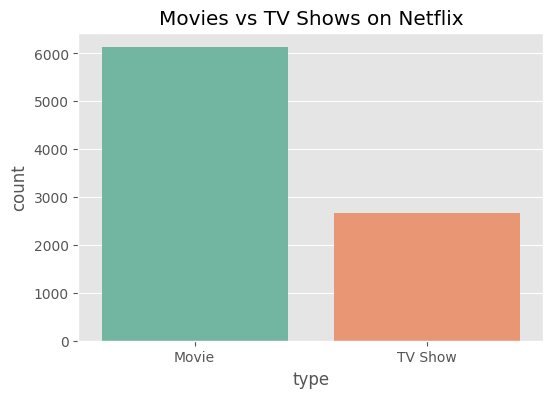

In [6]:
# ---------------------------------------------
# 3. Exploratory Data Analysis (EDA)
# ---------------------------------------------

## (a) Movies vs TV Shows
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='type', palette="Set2")
plt.title("Movies vs TV Shows on Netflix")
plt.show()

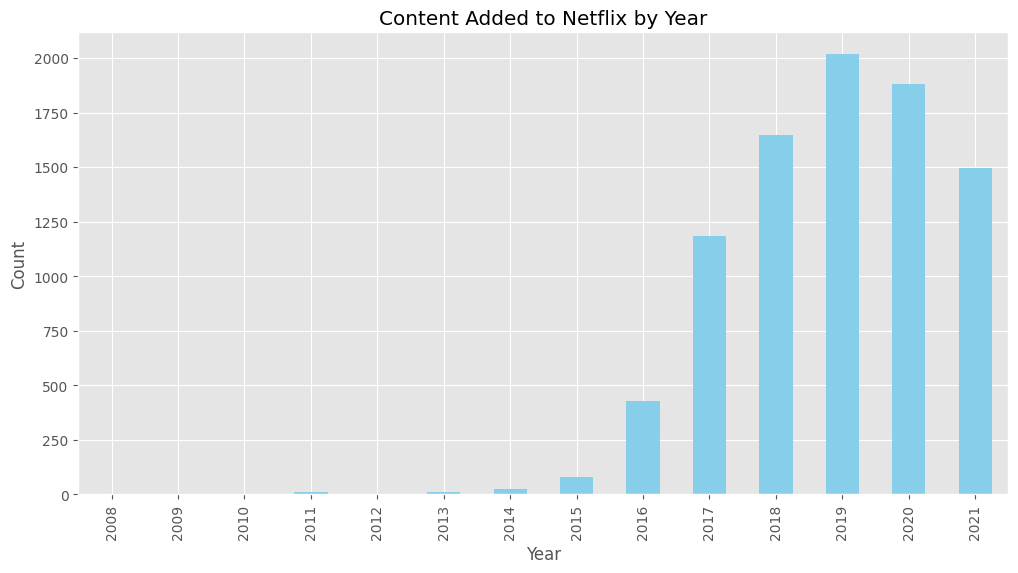

In [7]:
## (b) Content added over the years
df['year_added'] = df['date_added'].dt.year
content_by_year = df['year_added'].value_counts().sort_index()

plt.figure(figsize=(12,6))
content_by_year.plot(kind="bar", color="skyblue")
plt.title("Content Added to Netflix by Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

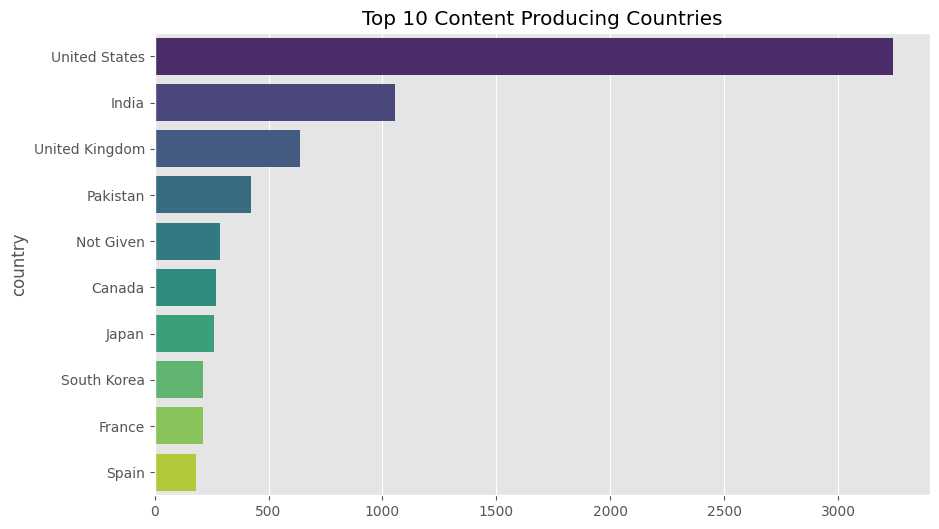

In [8]:
## (c) Top 10 Countries contributing content
top_countries = df['country'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="viridis")
plt.title("Top 10 Content Producing Countries")
plt.show()

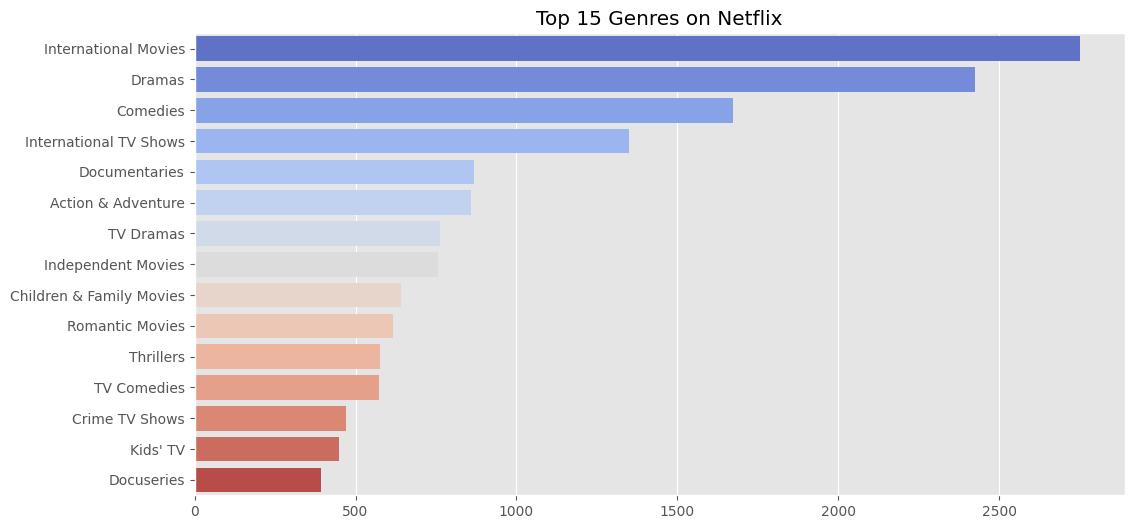

In [9]:
## (d) Most common genres (using 'listed_in')
from collections import Counter
genre_list = []
for s in df['listed_in'].dropna():
    genre_list.extend([g.strip() for g in s.split(",")])

genre_count = Counter(genre_list).most_common(15)

plt.figure(figsize=(12,6))
sns.barplot(x=[c[1] for c in genre_count], y=[c[0] for c in genre_count], palette="coolwarm")
plt.title("Top 15 Genres on Netflix")
plt.show()


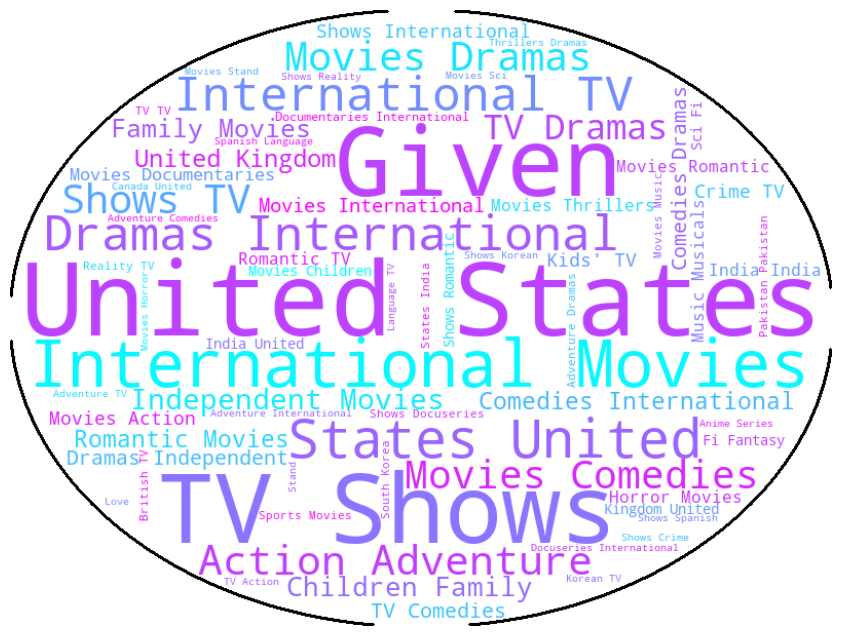

In [11]:
## (f) wordcloud

text = ' '.join(df['title'].astype(str)) + ' ' \
       + ' '.join(df['director'].astype(str)) + ' ' \
       + ' '.join(df['country'].astype(str)) + ' ' \
       + ' '.join(df['listed_in'].astype(str))


height = 600
width = 800
x, y = np.ogrid[:height, :width]
mask = ((x - height/2)**2) / (height/2)**2 + ((y - width/2)**2) / (width/2)**2 > 1
mask = 255 * mask.astype(int)

# Generate WordCloud
wordcloud = WordCloud(width=width, height=height,
                      background_color='white',
                      colormap='cool',
                      contour_color='black',
                      contour_width=2,
                      mask=mask,
                      max_words=250,
                      random_state=42,
                      prefer_horizontal=0.7,
                      min_font_size=10,
                      max_font_size=120).generate(text)

# Display
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# ---------------------------------------------
# Feature Engineering
# ---------------------------------------------

# (a) Number of genres
df['num_genres'] = df['listed_in'].apply(lambda x: len(str(x).split(",")))

# (b) Duration in minutes (for movies)
def convert_duration(x):
    if "min" in str(x):
        return int(str(x).replace("min","").strip())
    elif "Season" in str(x):
        return int(str(x).split()[0]) * 60  # approx. 1 season = 60 min
    else:
        return np.nan

df['duration_mins'] = df['duration'].apply(convert_duration)

# (c) Extract year/month from date_added
df['month_added'] = df['date_added'].dt.month
df['day_added'] = df['date_added'].dt.day

# (d) Flag long movies (>120 min)
df['long_movie'] = df['duration_mins'].apply(lambda x: 1 if pd.notna(x) and x > 120 else 0)

print(df[['title','listed_in','num_genres','duration','duration_mins','long_movie']].head())


                              title  \
0              Dick Johnson Is Dead   
1                         Ganglands   
2                     Midnight Mass   
3  Confessions of an Invisible Girl   
4                           Sankofa   

                                           listed_in  num_genres  duration  \
0                                      Documentaries           1    90 min   
1  Crime TV Shows, International TV Shows, TV Act...           3  1 Season   
2                 TV Dramas, TV Horror, TV Mysteries           3  1 Season   
3                 Children & Family Movies, Comedies           2    91 min   
4   Dramas, Independent Movies, International Movies           3   125 min   

   duration_mins  long_movie  
0             90           0  
1             60           0  
2             60           0  
3             91           0  
4            125           1  


In [ ]:
# ---------------------------------------------
# Machine Leaning
# ---------------------------------------------

#(a) Content-Based Recommendation System

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load dataset
df = pd.read_csv("netflix1.csv")

# Use only available text-based columns
text_features = ['title', 'director', 'listed_in', 'country']

# Combine them into a single feature
df['combined'] = df[text_features].fillna('').agg(' '.join, axis=1)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined'])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Recommendation function
def recommend(title, n=5):
    if title not in df['title'].values:
        return ["❌ Title not found in dataset."]
    idx = df[df['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]  # skip the same movie itself
    movie_indices = [i[0] for i in sim_scores]
    return df['title'].iloc[movie_indices].tolist()

# Example
print("🎬 Recommendations for 'Darr Sabko Lagta Hai':")
print(recommend("Darr Sabko Lagta Hai", n=5))




🎬 Recommendations for 'Darr Sabko Lagta Hai':
['Fear Files... Har Mod Pe Darr', 'She', 'WHAT / IF', 'Zindagi Gulzar Hai', 'Nevertheless,']


Predicted content additions by year:
2022 : 1895
2023 : 2064
2024 : 2233
2025 : 2402
2026 : 2571
2027 : 2740
2028 : 2909
2029 : 3078


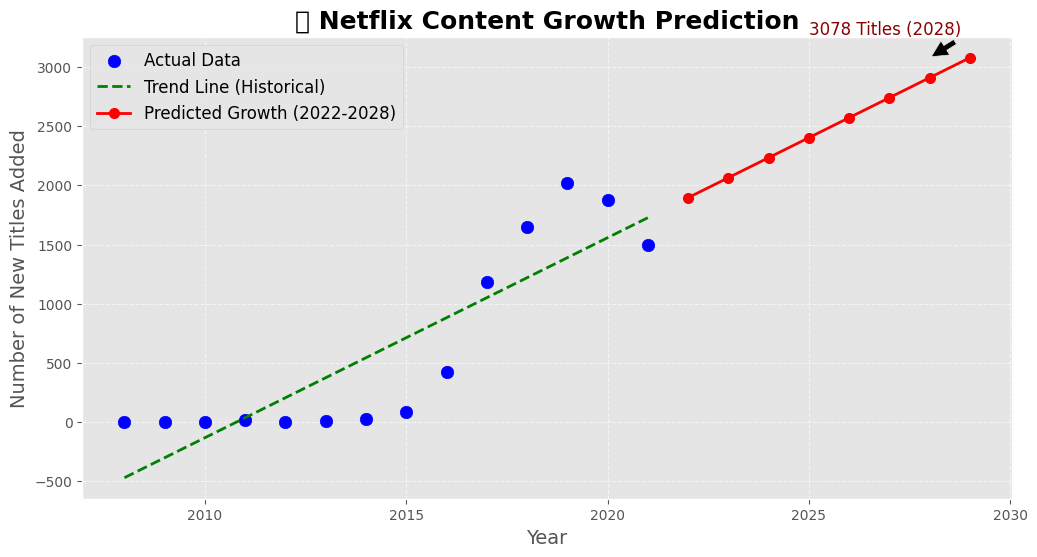

In [ ]:

# ---------------------------------------------
# Machine Learning Predictions
# ---------------------------------------------

from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Make sure date_added is datetime
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# Extract year_added
df['year_added'] = df['date_added'].dt.year

# Drop NaN years (if any)
df = df.dropna(subset=['year_added'])

# Aggregate by year
yearly = df['year_added'].value_counts().sort_index().reset_index()
yearly.columns = ['year','count']

# Features (X) and Target (y)
X = yearly['year'].values.reshape(-1,1)
y = yearly['count'].values

# Train Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict for future years (2022–2029)
future_years = np.array(range(2022, 2030)).reshape(-1,1)
pred = model.predict(future_years)

# Results
print("Predicted content additions by year:")
for year, val in zip(future_years.flatten(), pred.astype(int)):
    print(year, ":", val)


import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Actual data (blue dots)
plt.scatter(yearly['year'], yearly['count'], color='blue', s=80, label='Actual Data')

# Regression trend line (green dashed)
plt.plot(yearly['year'], model.predict(X), color='green', linestyle='--', linewidth=2, label='Trend Line (Historical)')

# Predictions (red line with circles)
plt.plot(future_years, pred, color='red', marker='o', markersize=7, linewidth=2, label='Predicted Growth (2022-2028)')

# Highlight last prediction (2028)
plt.annotate(f"{int(pred[-1])} Titles (2028)",
             xy=(2028, pred[-1]),
             xytext=(2025, pred[-1]+200),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, color='darkred')

# Titles & labels
plt.title("📈 Netflix Content Growth Prediction", fontsize=18, fontweight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of New Titles Added", fontsize=14)

# Grid & legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

plt.show()



In [30]:
# ---------------------------------------------
# Advanced Visualization
# ---------------------------------------------


import plotly.express as px

# Interactive content growth
fig = px.bar(yearly, x="year", y="count", 
             title="Netflix Content Added Over the Years",
             labels={"count":"Number of Titles"},
             color="count",
             text="count")
fig.show()
